In [20]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import plotly.express as px



#from tensorflow.keras.applications import ResNet50, ResNet50V2
#from tensorflow.keras.applications import Xception, InceptionV3
#from tensorflow.keras.applications import ResNet152, ResNet152V2
#from tensorflow.keras.applications import EfficientNetB3, EfficientNetB5


/Users/shahzadjalil/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Setting up the path and directories

In [60]:

data_dir = "./archive"
train_data_dir = os.path.join(data_dir)
test_data_dir = os.path.join(data_dir)
train_csv_path = os.path.join(data_dir, "train.csv")
test_csv_path = os.path.join(data_dir, "test.csv")

# Load csv files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)



Training Data:
   Unnamed: 0                                        file_name  label
0           0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1           1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2           2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3           3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4           4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1
Null values in training metadata:
Unnamed: 0    0
file_name     0
label         0
dtype: int64


check if there are any null values in the train and test datasets 

In [62]:
#
print("Null values in training:")
print(train_df.isnull().sum())

print("Null values in testing:")
print(test_df.isnull().sum())



Null values in training:
Unnamed: 0    0
file_name     0
label         0
dtype: int64
Null values in testing:
id    0
dtype: int64


As we can see above in both datasets we have no null values, therefore no need to remove anything from the datasets. 

In [63]:
# Sample train data
print("Training Data:")
print(train_df.head())

# Sample test data
print("Testing Data:")
print(test_df.head())

Training Data:
   Unnamed: 0                                        file_name  label
0           0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1           1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2           2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3           3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4           4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1
Testing Data:
                                                  id
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


In [64]:
# Check class distribution
print("Class Distribution:")
print(train_df['label'].value_counts())

Class Distribution:
label
1    39975
0    39975
Name: count, dtype: int64


We have equal number of data for each categry (human, AI)

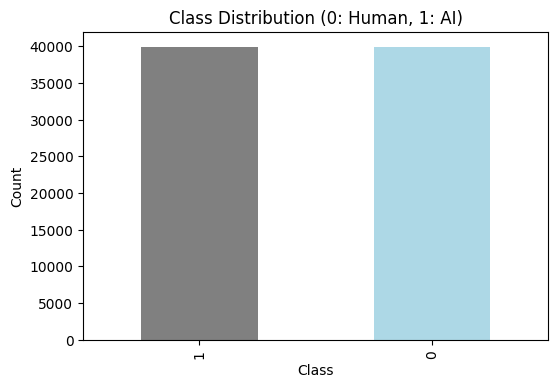

In [70]:
# Plot distribution
plt.figure(figsize=(6, 4))
train_df['label'].value_counts().plot(kind='bar', color=['grey', 'lightblue'])
plt.title("Class Distribution (0: Human, 1: AI)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

Display sample images

10 Sample Training Images:


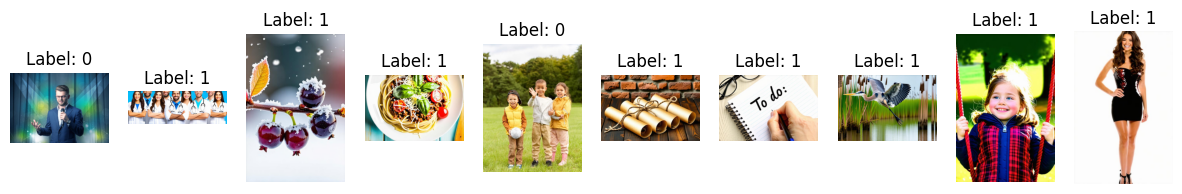

In [72]:

# Function to display 10 sample images
def display_sample_images(data_dir, df, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, (_, row) in enumerate(df.sample(num_samples).iterrows()):
        img_path = os.path.join(data_dir, row['file_name'])
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {row['label']}")
        axes[i].axis('off')
    plt.show()

print("10 Sample Training Images:")
display_sample_images(train_data_dir, train_df)

10 Sample test Images:


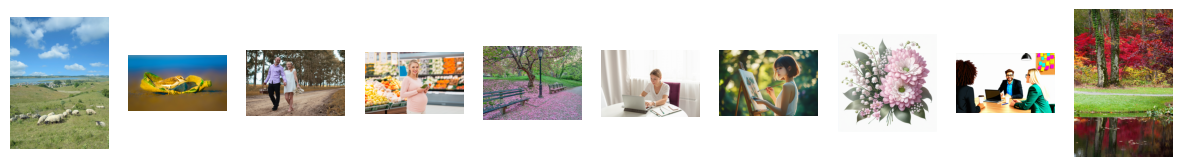

In [75]:
# Function to display sample images
def display_sample_images(data_dir, df, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, (_, row) in enumerate(df.sample(num_samples).iterrows()):
        img_path = os.path.join(data_dir, row['id'])
        img = Image.open(img_path)
        axes[i].imshow(img)
        
        axes[i].axis('off')
    plt.show()

# Display sample images from training data
print("10 Sample test Images:")
display_sample_images(test_data_dir, test_df)

Check Image resolutions:

In [76]:

def check_resolutions(data_dir, df):
    resolutions = []
    for _, row in df.iterrows():
        img_path = os.path.join(data_dir, row['file_name'])
        img = Image.open(img_path)
        resolutions.append(img.size)
    return resolutions

train_resolutions = check_resolutions(train_data_dir, train_df)
print("Training Image Resolutions:")
print(pd.Series(train_resolutions).value_counts())

Training Image Resolutions:
(768, 512)    41798
(512, 768)    11648
(768, 496)     5488
(768, 576)     2440
(768, 768)     1598
              ...  
(400, 768)        4
(768, 112)        4
(320, 768)        4
(336, 768)        2
(768, 128)        2
Name: count, Length: 70, dtype: int64


From both the sample pictures and resolutions above we can see that images have different sizes, so we need to preprocess the data.